<a href="https://colab.research.google.com/github/densivanov/data_analytics_projects/blob/main/uber_analysis/BigQuery_analysis_PySparkSQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing libraries

In [ ]:
import pandas as pd

!pip install pyspark py4j
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Analysis").getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Getting data

In [23]:
df = spark.read.parquet("/content/new_df_.parquet")

In [24]:
df.show()

+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|           Pull_Zone|
+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|         141|        Cash|        9.3|  1.0|    0.5|       0.0|         0.0|                  1.0|        14.3|                 2.5|        0.0|      Midtown Center|
| 2023-01-01 00:55:08|  2023-01-01 01:01

#Database documentation

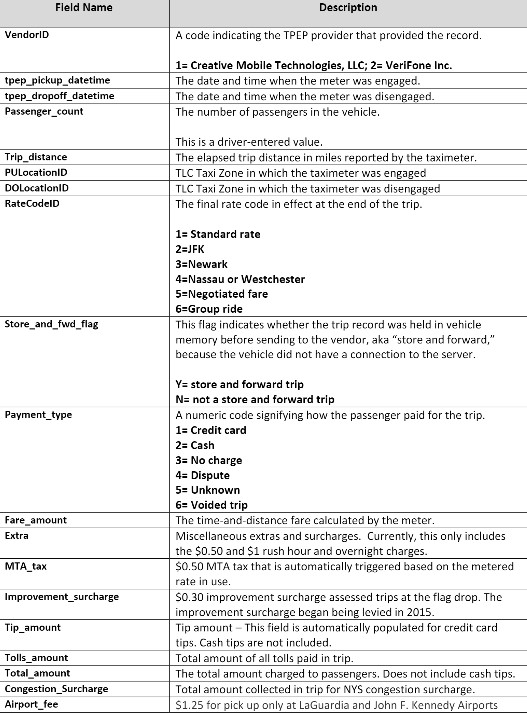

# Creating a view

In [25]:
# Create SQL table
spark.read.parquet("/content/new_df_.parquet") \
          .createOrReplaceTempView("df")

In [26]:
spark.sql('''
          SELECT *
          FROM df


''').show()

+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|           Pull_Zone|
+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|         141|        Cash|        9.3|  1.0|    0.5|       0.0|         0.0|                  1.0|        14.3|                 2.5|        0.0|      Midtown Center|
| 2023-01-01 00:55:08|  2023-01-01 01:01

#Analysis


#### Question №1: Output the average, maximum and minimum distance of the trip

In [28]:
spark.sql('''SELECT ROUND(AVG(trip_distance),2) AS avg_distance_mile,
                    ROUND(MAX(trip_distance),2) AS max_distance_mile,
                    ROUND(MIN(trip_distance),2) AS min_distance_mile
             FROM df
             
             
             
             ''') \
     .show()

+----------------+----------------+----------------+
|avg_distance_mil|max_distance_mil|min_distance_mil|
+----------------+----------------+----------------+
|            3.44|        62359.52|             0.0|
+----------------+----------------+----------------+



As we can see, the average distance of the trip is 3.44 mile

#### Qustion №2: Print the average duration of the trip by the hour

In [30]:
spark.sql('''SELECT EXTRACT(HOUR FROM tpep_pickup_datetime) AS pull_hour,
                    ROUND(AVG(trip_distance),2) AS avg_distance_mile
             FROM df
             GROUP BY EXTRACT(HOUR FROM tpep_pickup_datetime)
             ORDER BY EXTRACT(HOUR FROM tpep_pickup_datetime) ASC
             
             
             
             ''') \
     .show()

+---------+-----------------+
|pull_hour|avg_distance_mile|
+---------+-----------------+
|        0|             3.97|
|        1|             3.43|
|        2|             3.15|
|        3|             3.41|
|        4|              4.5|
|        5|             6.15|
|        6|             4.69|
|        7|             3.62|
|        8|             3.13|
|        9|             3.04|
|       10|             3.09|
|       11|             2.99|
|       12|             3.06|
|       13|             3.23|
|       14|             3.54|
|       15|             3.68|
|       16|             3.45|
|       17|             3.25|
|       18|              2.9|
|       19|              3.8|
+---------+-----------------+
only showing top 20 rows



#### Question №3 : Show metrics on the trip time

In [29]:
spark.sql('''SELECT ROUND(AVG(DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime)),2) AS avg_minute_trip,
                    ROUND(MAX(DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime)),2) AS max_minute_trip,
                    ROUND(MIN(DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime)),2) AS min_minute_trip
             FROM df
             
             
             
             ''') \
     .show()

+---------------+---------------+---------------+
|avg_minute_trip|max_minute_trip|min_minute_trip|
+---------------+---------------+---------------+
|          15.15|          10029|            -29|
+---------------+---------------+---------------+



The average trip takes 15 minutes. However we have outliers in the data let's see where exactly

#### Checking outliers in datetime

In [31]:
spark.sql('''SELECT tpep_pickup_datetime,
                    tpep_dropoff_datetime,
                    passenger_count,
                    trip_distance,
                    payment_type
                    fare_amount,
                    tip_amount,
                    total_amount
             FROM df
             WHERE DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime) IN (SELECT MAX(DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime))
                                                                                   FROM df)
             
             
             
             ''') \
     .show()

+--------------------+---------------------+---------------+-------------+-----------+----------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|fare_amount|tip_amount|total_amount|
+--------------------+---------------------+---------------+-------------+-----------+----------+------------+
| 2023-01-23 11:21:51|  2023-01-30 10:31:02|            1.0|          0.0|       Cash|       0.0|         4.5|
+--------------------+---------------------+---------------+-------------+-----------+----------+------------+



It is not difficult to understand that this is most likely a failure in information. You can see that the distance of the trip is 0 km, but the final cost is 4.5 dollars, which is quite strange

#### Question №4: How many passengers per hour on average?

In [ ]:
spark.sql('''SELECT EXTRACT(HOUR FROM tpep_pickup_datetime) AS hour,
                    ROUND(AVG(passenger_count),2) AS avg_pass_count,
                    MAX(passenger_count) AS max_pass_count
             FROM df
             GROUP BY EXTRACT(HOUR FROM tpep_pickup_datetime)
             ORDER BY ROUND(AVG(passenger_count),2) DESC
             
             
             
             
             ''') \
     .show()

+----+--------------+--------------+
|hour|avg_pass_count|max_pass_count|
+----+--------------+--------------+
|   2|          1.44|           6.0|
|   1|          1.43|           6.0|
|   0|          1.42|           8.0|
|  22|          1.41|           6.0|
|   3|          1.41|           7.0|
|  23|           1.4|           6.0|
|  21|           1.4|           6.0|
|   4|          1.39|           6.0|
|  16|          1.38|           8.0|
|  20|          1.38|           8.0|
|  15|          1.38|           8.0|
|  19|          1.37|           7.0|
|  14|          1.37|           8.0|
|  13|          1.36|           8.0|
|  17|          1.36|           8.0|
|  12|          1.35|           7.0|
|  18|          1.35|           8.0|
|  11|          1.34|           8.0|
|  10|          1.32|           6.0|
|   5|           1.3|           6.0|
+----+--------------+--------------+
only showing top 20 rows



The best hour for the average number of customers is 2 hours, but it is clear that on average there is one passenger everywhere. The quantity does not differ critically.


The table also shows the maximum number of passengers at a time

**Show the table**

In [32]:
spark.sql('''
          SELECT *
          FROM df


''').show()

+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|           Pull_Zone|
+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|         141|        Cash|        9.3|  1.0|    0.5|       0.0|         0.0|                  1.0|        14.3|                 2.5|        0.0|      Midtown Center|
| 2023-01-01 00:55:08|  2023-01-01 01:01

#### Question №5: Display the average trip time by the hour

In [36]:
spark.sql('''
          SELECT EXTRACT(HOUR FROM tpep_pickup_datetime) AS pull_hour,
                 ROUND(AVG(DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime)),2) AS avg_minute_time
          FROM df
          GROUP BY EXTRACT(HOUR FROM tpep_pickup_datetime)
          ORDER BY ROUND(AVG(DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime)),2) DESC
          


''').show()

+---------+---------------+
|pull_hour|avg_minute_time|
+---------+---------------+
|       16|          17.03|
|       15|          17.02|
|       14|           17.0|
|       17|          16.37|
|       13|          15.61|
|        8|          15.12|
|        0|          14.97|
|        5|          14.92|
|       12|          14.85|
|        4|          14.83|
|       23|          14.78|
|        9|          14.71|
|       10|           14.7|
|       18|          14.69|
|       11|          14.64|
|        6|           14.6|
|        7|          14.57|
|       22|          14.48|
|        1|          14.26|
|       19|          14.01|
+---------+---------------+
only showing top 20 rows



#### Question №6: What type of payment is used most often?

In [ ]:
spark.sql('''
          SELECT  payment_type,
                  COUNT(payment_type) AS count_payment_type,
                  ROUND(AVG(total_amount),2) AS avg_total_amount,
                   ROUND(AVG(tip_amount),2) AS avg_tip_amount,
                  ROUND(MAX(total_amount),2) AS max_total_amount


                 
          FROM df
          GROUP BY payment_type
          ORDER BY COUNT(payment_type) DESC
       


''').show()

+------------+------------------+----------------+--------------+----------------+
|payment_type|count_payment_type|avg_total_amount|avg_tip_amount|max_total_amount|
+------------+------------------+----------------+--------------+----------------+
| Credit card|           2411462|            28.3|          4.17|          545.55|
|        Cash|            532241|           23.03|           0.0|          1169.4|
|     Dispute|             33297|            2.55|          0.05|           603.5|
|   No charge|             18023|           10.51|          0.03|          1000.0|
+------------+------------------+----------------+--------------+----------------+



The table shows that a credit card is most often used to pay for a trip.

I also brought out the main indicators by type of payment.

#### Question №7: Show the biggest tip amount

In [38]:
spark.sql('''
          SELECT DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime) AS trip_minutes,
                 passenger_count,
                 trip_distance,
                 payment_type,
                 fare_amount,
                 tip_amount,
                 total_amount
                 
          FROM df
          WHERE tip_amount IN (SELECT MAX(tip_amount)
                               FROM df)
       


''').show()

+------------+---------------+-------------+------------+-----------+----------+------------+
|trip_minutes|passenger_count|trip_distance|payment_type|fare_amount|tip_amount|total_amount|
+------------+---------------+-------------+------------+-----------+----------+------------+
|           8|            2.0|         1.46| Credit card|       10.7|     380.8|       395.5|
+------------+---------------+-------------+------------+-----------+----------+------------+



The maximum tip was $ 380, but it is clear that the trip took only 8 minutes, perhaps we are working with an outlier again

#### Question №8: What is the most profitable places?

In [42]:
spark.sql('''
          SELECT Pull_Zone,
                 ROUND(AVG(total_amount),2) AS avg_total_amount
                 
          FROM df
          WHERE Pull_Zone IS NOT NULL
          GROUP BY Pull_Zone
          ORDER BY AVG(total_amount) DESC
          LIMIT 5
          
       


''').show()

+--------------------+----------------+
|           Pull_Zone|avg_total_amount|
+--------------------+----------------+
|      Newark Airport|          104.34|
|         Great Kills|            94.0|
|       Arden Heights|           90.74|
|        Baisley Park|           80.79|
|Flushing Meadows-...|           76.11|
+--------------------+----------------+

